<a href="https://colab.research.google.com/github/ThatManRong/RL_Thesis/blob/Single-Asset/HeapMap_Jan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generate Sample Paths

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from plotly import tools
from plotly.graph_objs import *
from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [2]:
def SimPaths(S0, kappa, theta, sigma, T, Ndt, Nsims):
    
    # time grid
    t = np.linspace(0, T, Ndt+1)
    dt = t[1]-t[0]
    sqrt_dt = np.sqrt(dt)

    # effective vol for large time steps
    #   sigma_eff = sigma *sqrt( (1-exp(-2*kappa*dt)) / (2*kappa) )
    #             ~ sigma *sqrt(  ( 1 - (1-2*kappa*dt + ..) ) /(2 *kappa) )
    #             ~ sigma *sqrt(  dt )
    sigma_eff = sigma * np.sqrt( (1-np.exp(-2*kappa*dt)) / (2*kappa))

    # store the sample paths
    X = np.zeros((Nsims, Ndt+1))
    Y = np.zeros((Nsims, Ndt+1))
    Z = np.zeros((Nsims, Ndt+1))

    X[:,0] = S0[0]
    Y[:,0] = S0[1]
    Z[:,0] = S0[2]


    for i in range(Ndt):

#         # Euler discretization of the SDE
#         #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
#         dW_x = sqrt_dt * np.random.randn(Nsims)
#         X[:,i+1] = X[:,i]  + kappa[0] * (theta[0] - X[:,i]) * dt + sigma[0] * dW_x

#         # Euler discretization of the SDE
#         #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
#         dW_y = sqrt_dt * np.random.randn(Nsims)
#         Y[:,i+1] = Y[:,i] + kappa[1] * (theta[1] - Y[:,i]) * dt + sigma[1] * dW_y

        # Exact solution to the SDE
        #  dX_t = \kappa_X(\theta_X-X_t)\,dt + \sigma_X\,d\boldsymbol{W}_t^X
        N_x =  np.random.randn(Nsims)
        X[:,i+1] = theta[0] + (X[:,i]-theta[0])*np.exp(-kappa[0]*dt) + sigma_eff[0] * N_x
        
        # Euler discretization of the SDE
        #  dY_t = \kappa_Y(\theta_Y-Y_t)\,dt + \sigma_Y\,d\boldsymbol{W}_t^Y
        N_y = np.random.randn(Nsims)
        Y[:,i+1] = theta[1] + (Y[:,i]-theta[1])*np.exp(-kappa[1]*dt) + sigma_eff[1] * N_y

        # update Z according to no-arbitrage
        Z[:,i+1] = 1.0/(X[:,i+1]*Y[:,i+1])
        
    return t, X, Y, Z

In [4]:
# model paramteres on hourly time scales
kappa = np.array([2, 2])
theta = np.array([1, 1.1])
sigma = np.array([1, 1])*1e-2

# initial values of the FX rates
X0 = 1.000
Y0 = 1.1 #1.0995
Z0 = 1.0/(X0*Y0)

T = 1 # in minutes
Ndt = 600 # in miliseconds

Nsims = 1000 # number of sims

t, X, Y, Z = SimPaths([X0, Y0, Z0], kappa, theta, sigma, T, Ndt, Nsims)

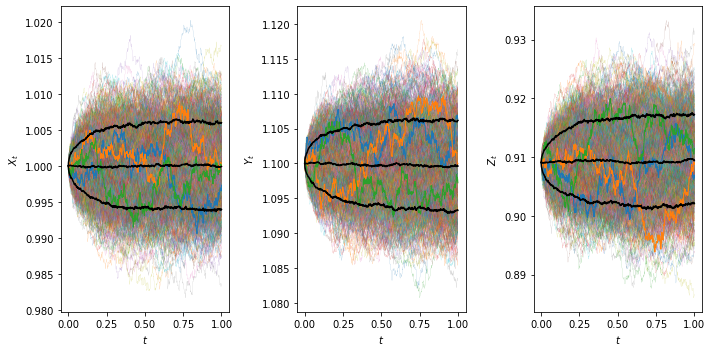

In [5]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, X.T, linewidth=0.1)
plt.plot(t, X[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(X,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$X_t$')

plt.subplot(1,3,2)
plt.plot(t, Y.T, linewidth=0.1)
plt.plot(t, Y[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Y,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Y_t$')

plt.subplot(1,3,3)
plt.plot(t, Z.T, linewidth=0.1)
plt.plot(t, Z[:3,:].T, linewidth=1)
plt.plot(t, np.quantile(Z,[0.1,0.5,0.9], axis=0).T, '-k')
plt.xlabel('$t$')
plt.ylabel('$Z_t$')

fig.tight_layout()

plt.show()

In [6]:
import pandas as pd
data = {'Time': t, 
        'X': X[0],
        'Y' : Y[0],
        'Z': Z[0]}
  
# Convert the dictionary into DataFrame 
data = pd.DataFrame(data) 
print(data)

         Time         X         Y         Z
0    0.000000  1.000000  1.100000  0.909091
1    0.001667  0.999532  1.100422  0.909167
2    0.003333  0.999425  1.100483  0.909214
3    0.005000  0.999040  1.100900  0.909220
4    0.006667  0.999144  1.101464  0.908660
..        ...       ...       ...       ...
596  0.993333  0.996929  1.106631  0.906428
597  0.995000  0.996897  1.106941  0.906203
598  0.996667  0.996707  1.106785  0.906503
599  0.998333  0.996518  1.106431  0.906965
600  1.000000  0.997302  1.106176  0.906460

[601 rows x 4 columns]


In [ ]:
# train_test_split = 0.5
# train = data[:int(train_test_split*len(data))]
# test = data[int(train_test_split*len(data)):]

#State: 
>$S_t=(X_t, P_t) $

where X is inventory and P is price

#Action: 
>$a_t = \{Buy, Sell, Hold\} $

#State Evolution
>$X_{t+1}= X_t + a_t $

>$P_{t+1}= f(P_t) + \epsilon $

In [7]:
class Environment2:
    
    def __init__(self, data, history_t = 10):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: sell, 
        #1: stay, 
        #2: buy
        if (self.t + 1 ==len(self.data)-1):
          act == 0
        max_holding = 8
        if act == 2:
            if len(self.positions)>=max_holding:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 0: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=max_holding:
          reward = -1
        # set next time
        self.t += 1
        #print(self.t)
        # if self.t == 49 and self.positions != [] and act != 2:
        #   reward = -1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period

        # if self.done and self.positions != []:
        #   reward = -1
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        #actual_action = act
        return [self.position_value] + self.history, reward, self.done, self.positions # obs, reward, done

In [ ]:
class Environment1:
    
    def __init__(self, data, history_t=20):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        reward = 0

        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if len(self.positions)>=20:
              reward = -1
            else:
              self.positions.append(self.data.iloc[self.t, :]['X'])
        elif act == 2: # sell
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['X'] - p)
                reward += profits
                self.profits += profits
                self.positions = []

        if len(self.positions)>=10:
          reward = -1
        
        # set next time
        self.t += 1
        
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['X'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['X'] - 1.0000)
        if (self.t==len(self.data)-1):
            self.done=True
            #self.positions = []
            #act = 2   #Force selling at end of period


        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        #print ("t={%d}, done={%str}"%(self.t,self.done))
        actual_action = act
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [8]:
class Q_Network(nn.Module):
        
    def __init__(self,obs_len,hidden_size,actions_n):
            
        super(Q_Network,self).__init__()
            
        self.fc_val = nn.Sequential(
            nn.Linear(obs_len, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actions_n)
        )
        
        
    def forward(self,x):
        h =  self.fc_val(x)
        return (h)

In [9]:
hidden_size=20
input_size=11
output_size=3
USE_CUDA = False
LR = 0.001

In [10]:
Q = Q_Network(input_size, hidden_size, output_size)

In [11]:
Q_ast = copy.deepcopy(Q)


In [12]:
if USE_CUDA:
    Q = Q.cuda()
    print("using Cuda")
loss_function = nn.MSELoss()
optimizer = optim.Adam(list(Q.parameters()), lr=LR)

In [13]:
#epoch_num = 20
memory_size = 6000
batch_size = 200
gamma = 0.99

memory = []
total_step = 0
total_rewards = []
total_losses = []
epsilon = 1.0
epsilon_decrease = 1e-3
epsilon_min = 0.01
start_reduce_epsilon = 200
train_freq = 10
update_q_freq = 20
gamma = 0.99
show_log_freq = 20


In [ ]:
# epoch_data = {'Time': t, 
#         'X': X[1]}
# epoch_data = pd.DataFrame(epoch_data) 
# env = Environment2(epoch_data)
# step_max = len(env.data)-1

In [ ]:
master_reward = []
#start = time.time()
for epoch in range(len(X[:int(Nsims/2)])):
    epoch_data = {'Time': t, 
        'X': X[epoch]}
    print("Percentage done: ", epoch/int(Nsims/2))
    epoch_data = pd.DataFrame(epoch_data) 
    env = Environment2(epoch_data)
    step_max = len(env.data)-1
    pobs = env.reset()
    step = 0
    done = False
    total_reward = 0
    total_loss = 0
    iterations = []
    log_rewards = []
    log_losses = []
    iteration = 1
    trading_history = []
    while not done and step < step_max:
        if done:
          trading_history = []  #For pair trading, make sure the stock
        # select action
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:  #Epsilon greedy Exploration
            pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
            pact = np.argmax(pact.data)
            pact = pact.numpy()
        if step == step_max - 1:
           pact = 2
        # act
        obs, reward, done, inventory = env.step(pact)
        #print("Step max is: ", step_max, "Inventory is: ", inventory)
        # if done is True:
        #     print("action is: ", actual_action, "  Reward is: ", reward, "  Done? ", done)

        # add memory
        memory.append((pobs, pact, reward, obs, done))
        #memory.append((pobs, actual_action, reward, obs, done))
        if len(memory) > memory_size:
            memory.pop(0)

        # train or update q
        if len(memory) == memory_size:
            if total_step % train_freq == 0:
                shuffled_memory = np.random.permutation(memory)
                memory_idx = range(len(shuffled_memory))
                for i in memory_idx[::batch_size]:
                    batch = np.array(shuffled_memory[i:i+batch_size])
                    b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                    b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                    b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                    b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                    q = Q(torch.from_numpy(b_pobs))
                    q_ = Q_ast(torch.from_numpy(b_obs))
                    maxq = np.max(q_.data.numpy(),axis=1)
                    target = copy.deepcopy(q.data)
                    for j in range(batch_size):
                        target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                    Q.zero_grad()
                    loss = loss_function(q, target)
                    total_loss += loss.data.item()
                    loss.backward()
                    optimizer.step()
                    
            if total_step % update_q_freq == 0:
                Q_ast = copy.deepcopy(Q)
                
            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        master_reward.append(total_rewards)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            
            iterations.append(iteration)
            iteration += 1
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_rewards.append(log_reward)
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            log_losses.append(log_loss)
            #elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss])))
            #start = time.time()
            
#return Q, total_losses, total_rewards

In [ ]:
print(len(total_rewards[:-600]))

In [ ]:
t_in_ms = [i for i in range(100)]
fig = plt.figure(figsize=(30,5))
plt.subplot(1,5,1)
plt.plot(t_in_ms, total_rewards[600:700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,2)
plt.plot(t_in_ms, total_rewards[9600:9700], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
plt.subplot(1,5,3)
plt.plot(t_in_ms, total_rewards[19200:19300], linewidth=1)
plt.xlabel('$t$')
plt.ylabel('$Rewards$')
# plt.subplot(1,5,4)
# plt.plot(t_in_ms, total_rewards[30000:30100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')
# plt.subplot(1,5,5)
# plt.plot(t_in_ms, total_rewards[40000:40100], linewidth=1)
# plt.xlabel('$t$')
# plt.ylabel('$Rewards$')

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(iterations, log_rewards, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Rewards')
plt.subplot(1,2,2)
plt.plot(iterations, log_losses, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('Losses')

In [ ]:
print(len(log_rewards))
incremental_reward = []
for i in range(len(log_rewards)):
  if i>=1:
    incremental_reward.append((log_rewards[i]-log_rewards[i-1])/memory_size)


In [ ]:
fig = plt.figure(figsize=(10,5))
plt.plot(iterations[:-1], incremental_reward, linewidth=1)
plt.xlabel('iterations')
plt.ylabel('incremental_reward')

In [19]:
test_data = {'Time': t, 
        'X': X[999]}
test_data = pd.DataFrame(test_data) 
test_env = Environment2(test_data)

In [20]:
#test_env = Environment1(X[100])
pobs = test_env.reset()
test_acts = []
test_rewards = []
inventory = []
for _ in range(len(test_env.data)-1):
    
    pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
    pact = np.argmax(pact.data)
    
    #print(pact.numpy())        
    obs, reward, done, epoch_inventory = test_env.step(pact.numpy())
    inventory.append(len(epoch_inventory))
    test_acts.append(pact.numpy())
    test_rewards.append(reward)

    pobs = obs
        
test_profits = test_env.profits

In [ ]:
print(len(inventory))

50


In [22]:
buy_point = []
buy_time = []
sell_point = []
sell_time = []
for i in range(len(test_acts)):
  if test_acts[i] == 2:
    buy_point.append(X[999][i])
    buy_time.append(i/len(test_acts))
  if test_acts[i] == 0:
    sell_point.append(X[999][i])
    sell_time.append(i/len(test_acts))

In [ ]:
fig = plt.figure(figsize=(30,5))
plt.plot(t,X[999])
plt.plot(buy_time, buy_point, 'o', color='green')
plt.plot(sell_time, sell_point, 'x', color='red');
plt.legend(["Price Movement","Buy Action","Sell Action"])
#print(mark)
plt.show()

In [ ]:
t_in_ms = [i for i in range(len(test_rewards))]
plt.plot(t_in_ms, test_rewards, linewidth=1)

In [ ]:
print(test_profits)

0.0014766291209185045


In [26]:
#Try all sample path
samplepath_number = []
test_profits = []
actions = []
all_inventory = []
for i in range(0,len(X)):
  epoch_action = []
  inventory = []
  test_data = {'Time': t, 
        'X': X[i]}
  # Convert the dictionary into DataFrame 
  test_data = pd.DataFrame(test_data) 
  test_env = Environment2(test_data)
  pobs = test_env.reset()
  test_acts = []
  test_rewards = []
  print("Percentage done: ", i*100/len(X))
  for i in range(len(test_env.data)-1):
      #inventory.append(0)
      pact = Q(torch.from_numpy(np.array(pobs, dtype=np.float32).reshape(1, -1)))
      pact = np.argmax(pact.data)
      test_acts.append(pact.item())
      #print(pact.numpy())        
      # if pact.numpy() == 1:
      #   if i > 0:
      #     inventory[i] = inventory[i-1]+1

      obs, reward, done, epoch_inventory = test_env.step(pact.numpy())
      inventory.append(len(epoch_inventory))
      epoch_action.append(pact.numpy())
      test_rewards.append(reward)

      pobs = obs
  epoch_action[599] = 0
  actions.append(epoch_action)
  all_inventory.append(inventory)        
  test_profits.append(test_env.profits)
  samplepath_number.append(i+1)




Percentage done:  0.0
Percentage done:  0.1
Percentage done:  0.2
Percentage done:  0.3
Percentage done:  0.4
Percentage done:  0.5
Percentage done:  0.6
Percentage done:  0.7
Percentage done:  0.8
Percentage done:  0.9
Percentage done:  1.0
Percentage done:  1.1
Percentage done:  1.2
Percentage done:  1.3
Percentage done:  1.4
Percentage done:  1.5
Percentage done:  1.6
Percentage done:  1.7
Percentage done:  1.8
Percentage done:  1.9
Percentage done:  2.0
Percentage done:  2.1
Percentage done:  2.2
Percentage done:  2.3
Percentage done:  2.4
Percentage done:  2.5
Percentage done:  2.6
Percentage done:  2.7
Percentage done:  2.8
Percentage done:  2.9
Percentage done:  3.0
Percentage done:  3.1
Percentage done:  3.2
Percentage done:  3.3
Percentage done:  3.4
Percentage done:  3.5
Percentage done:  3.6
Percentage done:  3.7
Percentage done:  3.8
Percentage done:  3.9
Percentage done:  4.0
Percentage done:  4.1
Percentage done:  4.2
Percentage done:  4.3
Percentage done:  4.4
Percentage

In [ ]:
print(all_inventory[100])
print(actions[100])

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[array(2), array(0), array(2), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(2), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(2), array(1), array(1), array(1), array(1), array(0), array(2), array(0), array(2), array(1), array(1), array(0), array(1), array(1), array(1), array(1), array(2), array(2), array(2), array(2), array(1), array(0), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(1), array(2), array(1), array(0), array(1)

In [28]:
#Offset the inventory
updated_all_inventory = all_inventory
for i in range(len(all_inventory)):
  updated_all_inventory[i].insert(0,0)
  #del updated_all_inventory[i][0]
  del updated_all_inventory[i][len(all_inventory[0])-1]
  #updated_all_inventory[i][len(all_inventory[0])-1] = 0
print(updated_all_inventory[2])
print(len(updated_all_inventory[2]))

[0, 1, 0, 1, 2, 3, 0, 1, 1, 2, 3, 0, 1, 0, 1, 0, 1, 1, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 2, 3, 0, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 2, 3, 4, 0, 1, 0, 1, 2, 2, 3, 0, 1, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 3, 0, 1, 1, 2, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 2, 2, 3, 0, 1, 2, 3, 4, 4, 5, 0, 1, 2, 2, 3, 4, 5, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 4, 0, 1, 1, 2, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 3, 4, 0, 1, 0, 1, 2, 3, 4, 5, 6, 0, 1, 0, 1, 2, 3, 0, 1, 1, 2, 3, 3, 0, 1, 2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 0, 1, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 0, 1, 0, 1, 2, 3, 0, 1, 0, 1, 2, 0, 1, 2, 3, 4, 5, 0, 1, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 3, 4, 5, 0, 1, 2, 0, 1, 0, 1, 2, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 

In [29]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

In [ ]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [ ]:
print(flights)

In [42]:
#Begin of the day: t = 0
time_spot = 0
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i][time_spot])
  inventory_spot.append(updated_all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

In [31]:
print(df)
print(len(action_spot))

     price  inventory  action
0        1          0       2
1        1          0       2
2        1          0       2
3        1          0       2
4        1          0       2
..     ...        ...     ...
995      1          0       2
996      1          0       2
997      1          0       2
998      1          0       2
999      1          0       2

[1000 rows x 3 columns]
1000


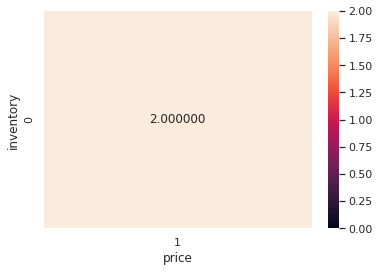

In [43]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f",vmax = 2, vmin = 0)


In [40]:
#End of the day: t = 99
time_spot = 599
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  price_spot.append(X[i][time_spot])
  inventory_spot.append(updated_all_inventory[i][time_spot])
  action_spot.append(actions[i][time_spot])
price_quartile = []
for i in range(len(price_spot)):
  if price_spot[i] <= np.quantile(price_spot,0.25):
    price_quartile.append(1)
  elif np.quantile(price_spot,0.25) < price_spot[i] <= np.quantile(price_spot,0.5):
    price_quartile.append(2)
  elif np.quantile(price_spot,0.5) < price_spot[i] <= np.quantile(price_spot,0.75):
    price_quartile.append(3)
  elif np.quantile(price_spot,0.75) < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

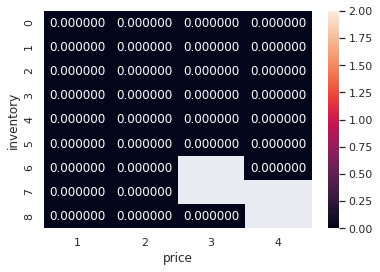

In [41]:
#df = sns.load_dataset("flights")
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f",vmax = 2, vmin = 0)


In [35]:
#Begin of the day: t = 0 to t = 50
time_spot = 25
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(0,50):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


In [36]:
def remove_outlier(df):
  for i in range(len(df)):
    for j in range(1,5):
      if df.xs(i)[j] == 1.00000 or df.xs(i)[j] == 0.00000 or df.xs(i)[j] == 2.00000:
        df.xs(i)[j] = float("NaN")
  return df
      

In [ ]:
print(table.xs(1)[2])
#df.xs('C')['x'] = 10

1.0005419962399011


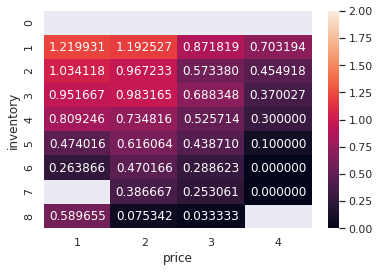

In [39]:
#df = sns.load_dataset("flights")
#from scipy import stats
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table, annot=True, fmt="f",vmax = 2, vmin = 0)


In [53]:
#Near middle of the day: t = 100 to t = 500
#time_spot = 25
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(100,500):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


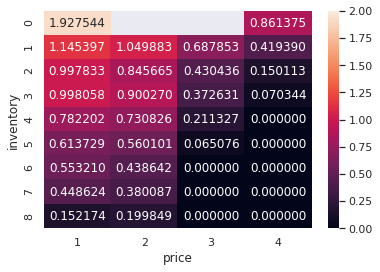

In [54]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f", vmax = 2, vmin = 0)

In [47]:
#Near end of the day: t = 550 to t = 600
#time_spot = 25
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(550,600):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


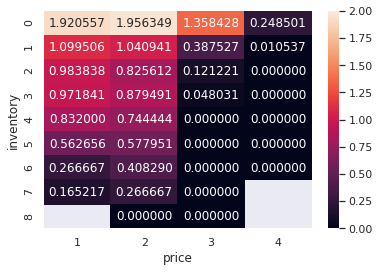

In [52]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f",vmax = 2, vmin = 0)

In [ ]:
#Beginning of the day: t = 0 
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(0,1):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


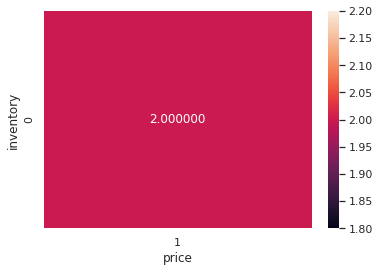

In [ ]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#table = remove_outlier(table)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f")

In [ ]:
#End of the day: t = 99 
inventory_spot = []
price_spot = []
action_spot = []
for i in range(len(actions)):
  for j in range(99,100):
    price_spot.append(X[i][j])
    inventory_spot.append(all_inventory[i][j])
    action_spot.append(actions[i][j])
price_quartile = []
print("Loaded")
first_quantile = np.quantile(price_spot,0.1)
second_quantile = np.quantile(price_spot,0.5)
third_quantile = np.quantile(price_spot,0.9)
print("Done")
for i in range(len(price_spot)):
  #print("Percent complete: ", i/len(price_spot))
  if price_spot[i] <= first_quantile:
    price_quartile.append(1)
  elif first_quantile < price_spot[i] <= second_quantile:
    price_quartile.append(2)
  elif second_quantile < price_spot[i] <= third_quantile:
    price_quartile.append(3)
  elif third_quantile < price_spot[i]:
    price_quartile.append(4)
data = np.transpose([price_quartile,inventory_spot,action_spot])  
df = pd.DataFrame(data, columns = ['price', 'inventory','action']) 

Loaded
Done


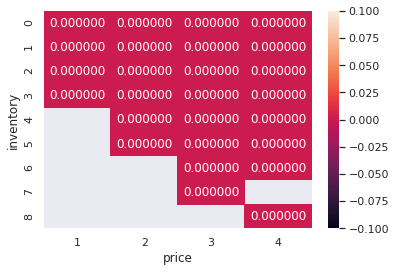

In [ ]:
table = pd.pivot_table(df, values='action', index=['inventory'], columns = ['price'],
                     aggfunc=np.mean)
#table = remove_outlier(table)

#print(table)
ax = sns.heatmap(table[:], annot=True, fmt="f")

(array([7.000e+00, 2.800e+01, 6.400e+01, 8.400e+01, 1.210e+02, 6.890e+02,
        1.855e+03, 2.887e+03, 2.168e+03, 9.220e+02, 5.042e+03, 7.573e+03,
        5.131e+03, 2.333e+03, 7.870e+02, 2.370e+02, 5.000e+01, 1.400e+01,
        4.000e+00, 4.000e+00]),
 array([-0.03909559, -0.03516176, -0.03122792, -0.02729408, -0.02336025,
        -0.01942641, -0.01549257, -0.01155874, -0.0076249 , -0.00369106,
         0.00024278,  0.00417661,  0.00811045,  0.01204429,  0.01597812,
         0.01991196,  0.0238458 ,  0.02777963,  0.03171347,  0.03564731,
         0.03958114]),
 <a list of 20 Patch objects>)

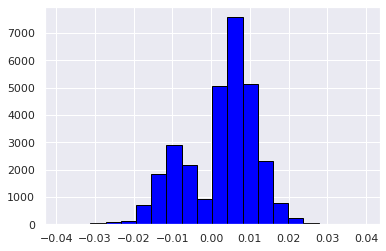

In [ ]:
plt.hist(test_profits, color = 'blue', edgecolor = 'black',
         bins = 20)

In [ ]:
YEAH = 0
NOOOO = 0
for elem in test_profits:
  if elem >= 0.0:
    YEAH += 1
  else:
    NOOOO -= 1

print("Percentage of Profitting: ", YEAH*100/(len(test_profits)),"%")

Percentage of Profitting:  71.07333333333334 %
